In [728]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1
def add_metadata(fname, d):
    match = re.search('width_mult_\d+', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = int(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
    match = re.search('seed_\d+', fname)
    if match:
        s = match.group(0)[len("seed_"):]
        d["seed"] = int(s)
    else:
        d["seed"] = None
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    match = re.search('parametr_', fname)
    if match:
        d['parametr'] = match.group(0)[len("parametr_"):]
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d
def get_data(folder_path, epoch=19):
    final_d = []
    for fp in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath)
            d = add_metadata(fp, d)
            d["name"] = fp
            final_d.append(d)
    return final_d
def loss_curves(run_ds, train=True, acc=True, neigs=1, nepochs=40):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        # try:
        if train:
            loss_d["train_loss"] =  d["metrics"]["train_loss"]
            # loss_d["residual"] = d["metrics"]["residual"]
            # loss_d["top_eig_ggn"] = d["metrics"]["top_eig_ggn"]
            # d["metrics"]["directional_sharpness"].insert(0, float('nan'))

            if acc:
                if "train_acc" in d["metrics"].keys():
                    loss_d["train_acc"] =  d["metrics"]["train_acc"]
            if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
                loss_d["trace"] = d["metrics"]["trace"]
            if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
                loss_d["top_eig"] = d["metrics"]["top_eig"]
        else:
            loss_d["test_loss"] =  d["metrics"]["test_loss"]
            loss_d["test_acc"] =  d["metrics"]["test_acc"]
        loss_d["lr"] = d["lr"]
        loss_d["seed"] = d["seed"]
        loss_d["width_mult"] = d["width_mult"]
        loss_d["Width"] = d["width_mult"] * 64
        loss_d["depth_mult"] = d["depth_mult"]
        if neigs > 1:
            for eigi in range(neigs):
                loss_d[f"top_eig_{eigi}"] =  d["metrics"][f"top_eig_{eigi}"]
        loss_d["step"] = loss_d.index
        loss_d["Epoch"] = (loss_d.index / loss_d.index.max()) * nepochs
        loss_d["beta"] = d["beta"]
        # loss_d["directional_sharpness"] = d["metrics"]["directional_sharpness"]
        loss_d["gamma_zero"] = d["gamma_zero"]
        loss_d["k_layers"] = d["k_layers"]
        loss_d["batch_size"] = d["batch_size"]
        ds.append(loss_d)
        # except KeyError:
        #     continue
    return pd.concat(ds, axis=0)
def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            l = [metric, 'seed', 'directional_sharpness', 'lr', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size']
            if neigs > 1:
                for eigi in range(5):
                    l.append(f'top_eig_{eigi}')
            else:
                d.append('top_eig')
            d = {k: d[k] for k in l}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [729]:
sns.set(style="whitegrid", font_scale=2.0, palette=sns.color_palette("rocket", n_colors=5))
plt.figure(figsize = (10,6))
folder_path = "/home/ameterez/work/nips2024/understanding_multiple_layers_per_block_longer_with_adam_no_scaling"
metric = "train_loss"
epochs = 49
run_ds = get_data(folder_path, epoch=epochs)
df = loss_curves(run_ds, acc=False, neigs=1, nepochs=epochs).reset_index()
df['Depth'] = df['depth_mult'] * 6

<Figure size 1000x600 with 0 Axes>

In [730]:
lrs = sorted(df.lr.unique())
print(lrs)

[0.0001, 0.000152, 0.000231, 0.000351, 0.000534, 0.000811, 0.001233, 0.001874, 0.002848, 0.004329, 0.006579, 0.01]


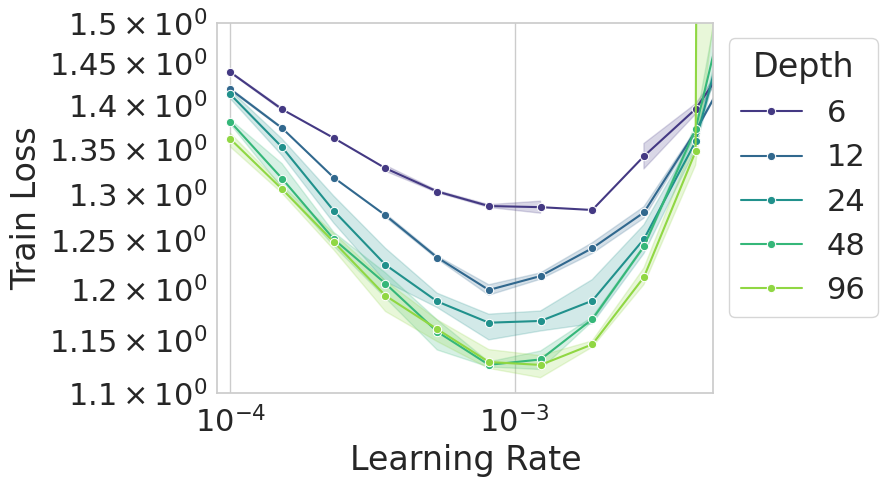

In [726]:
palette=sns.color_palette("viridis", n_colors=5)
df2 = df[df['step'] == df['step'].max()]
nlayers = 1
df2 = df2[df2['k_layers'] == nlayers]
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='lr', y='train_loss', hue='Depth', ax=ax, marker='o', palette=palette)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('Train Loss')
ax.set_xlabel('Learning Rate')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.1, 1.5)
ax.set_xlim(9e-5, 5e-3)
fig.savefig('conv_cifar10_muadam_no_scaling_transfer_1_per_block.pdf', bbox_inches='tight')
fig.show()

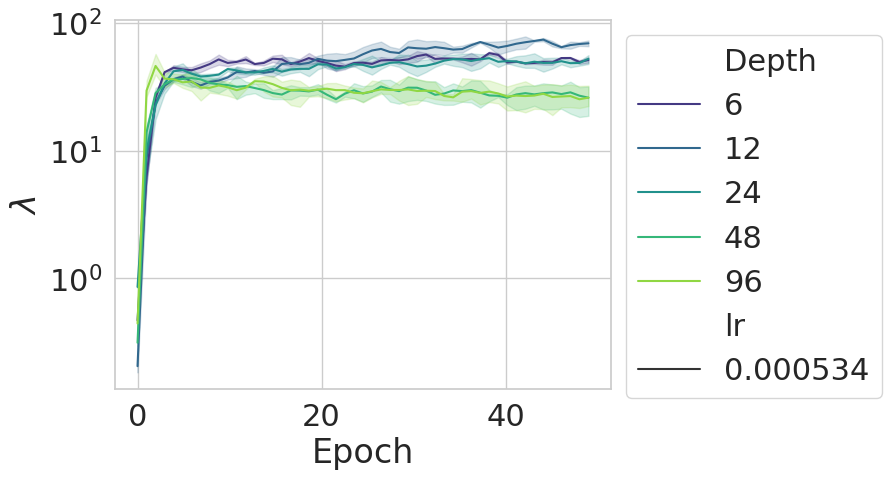

In [737]:
palette=sns.color_palette("viridis", n_colors=5)
nlayers = 2
df2 = df[df['lr'] == lrs[4]]
df2 = df2[df2['k_layers'] == nlayers]
df2['top_eig'] *= 32
df2['top_eig'] = df2.groupby(['seed', 'Depth'])['top_eig'].transform(lambda x: x.rolling(window=2, min_periods=1).mean())

# df2['top_eig'] *= (1 / np.sqrt(nlayers*df2['depth_mult']))

fig, ax = plt.subplots(ncols=1, nrows=1)
palettes = [sns.color_palette('viridis', 5)]
sns.lineplot(df2, x='Epoch', y=f'top_eig', hue='Depth', style='lr', ax=ax, palette=palettes[0], legend=ki==0)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
# ax.set_ylim(6e-2)
ax.set_ylabel('$\lambda$')
fig.savefig('conv_cifar10_muadam_no_scaling_sharpness_2_per_block.pdf', bbox_inches='tight')
fig.show()

In [75]:
## df3 = df2.melt(var_name='$\lambda_i$', value_name='eigenvalue', value_vars=['top_eig_0', 'top_eig_5', 'top_eig_9'], id_vars=['seed', 'Width', 'lr', 'Epoch'])
df3 = df3.replace({'top_eig_0': '$\lambda_0$','top_eig_5': '$\lambda_5$','top_eig_9': '$\lambda_9$',})
# df3['eigenvalue'] = df3.groupby(['seed', 'Width', '$\lambda_i$'])['eigenvalue'].rolling(2).mean()
df3['eigenvalue'] = df3.groupby(['seed', 'Width', '$\lambda_i$'])['eigenvalue'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
display(df3)

,seed,Width,lr,Epoch,$\lambda_i$,eigenvalue
0,0,256,0.5275,0.0,$\lambda_0$,0.055758
1,0,256,0.5275,1.0,$\lambda_0$,0.636722
2,0,256,0.5275,2.0,$\lambda_0$,0.704412
3,0,256,0.5275,3.0,$\lambda_0$,1.141511
4,0,256,0.5275,4.0,$\lambda_0$,1.138508
...,...,...,...,...,...,...
697,1,32,0.5275,21.0,$\lambda_9$,0.597008
698,1,32,0.5275,22.0,$\lambda_9$,0.597251
699,1,32,0.5275,23.0,$\lambda_9$,0.602095
700,1,32,0.5275,24.0,$\lambda_9$,0.588322


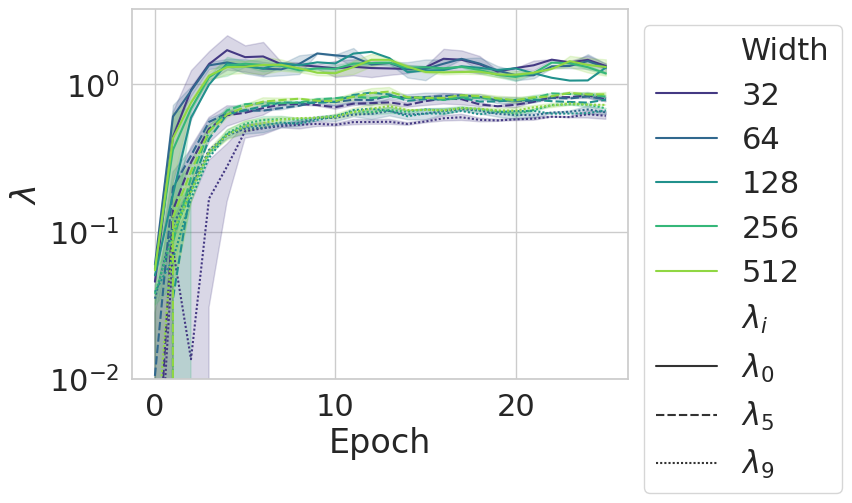

In [77]:
# df2 = df[df['lr'].isin([lrs[6]])]
palette=sns.color_palette("viridis", n_colors=5)

k = 0
fig, ax = plt.subplots(ncols=1, nrows=1)
# make new df

sns.lineplot(df3, x='Epoch', y=f'eigenvalue', hue='Width', style='$\lambda_i$', ax=ax, palette=palette, legend=True)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_ylim(1e-2)
ax.set_ylabel('$\lambda$')
fig.savefig('conv_cifar10_top_eigs_sharpness.pdf', bbox_inches='tight')
fig.show()